# Tutorial on Bilevel Optimization
## with Neural Implicit Differentiation

In [1]:
import numpy as np
import BilevelProblem
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

np.random.seed(0)

We now work with the linear regression example where $F_v$ is a $m_v\times n$ **validtaion set** feature matrix (every row is a feature vector of dimension $n$) and $l_v$ is an $m_t$ dimensional **validation set** label vector (every member is a label for a corresponding feature vector). Similarly, $F_t \in R^{m_t\times n}$ and $l \in R^{m_t}$ are in the **training set**. We have the outer objective:
$$
  F(x, h^*(x)) = \sum_{(w,v)\in D_v} \left( \frac{1}{m_v} \lVert h^*(w_v) - v_v \rVert_2^2 + x \lVert h^*(w_v) \rVert_{L_2}^2 \right)
$$
and the inner objective:
$$
  s.t.\ h^*(x)\in \arg \min_h G(x, h) = \sum_{(w,v)\in D_t} \left( \frac{1}{m_t} \lVert h(w_t) - v_t \rVert_2^2 + x \lVert h(w_t) \rVert_{L_2}^2 \right)
$$
We first set the dimensions and generate the data, in this example we have a linear $h^*(w)=\theta^T w$ (or $h^*(w)=\theta^T (1+w)$ ?) where $\theta$ is the coefficient vector **coef** and $w\in R_+^n$.

In [1]:
n = 2
m_v = 300
m_t = 700
m= m_v + m_t
#X, y, coef = make_regression(n_samples=m, n_features=n, n_informative=n, n_targets=1, noise=0, coef=True, random_state=10)
#X, y, coef = X*1/10, y*1/10, coef*1/10
coef = np.random.uniform(size=(n,1))
X = np.random.uniform(size=(m, n))
h_true = lambda X: X @ coef#(1+X) @ coef.T
y = h_true(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)
print("True coeficients:", coef)

NameError: name 'np' is not defined

We can visualize the training data in 3D:

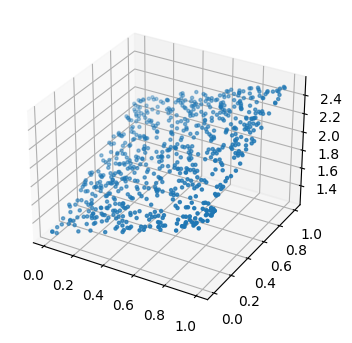

In [3]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.')
plt.show()

We then define both level losses and the necessary gradients:

In [4]:
def L2_norm(h, x, sample_size=10):
    """
    Returns an approximation of L2 function space norm
        param h: an L2 function
        param x: a random variable
    """
    sample = np.random.choice(X_train, size=sample_size)
    return np.mean(sample**2)

In [5]:
fo = lambda x, h, w, v: (1/m_v)*np.sum(np.array([((1/2)*np.sum(h(w)-v)**2+x*np.sum(h)**2) for (w, v) in (X_val, y_val)]))
fi = lambda x, h, w, v: (1/m_t)*np.sum(np.array([((1/2)*np.sum(h(w)-v)**2+x*np.sum(h)**2) for (w, v) in (X_train, y_train)]))
# Gradient wrt x of f
og1 = lambda x, h, X_out, y_out: L2_norm(h, x)
# Gradient wrt h of f
og2 = lambda x, h, X_out, y_out: X_out.T @ (X_out @ h(X_out) - y_out) + x*2*h(X_out)
# Gradient wrt h of gradient wrt h of g
ig22 = lambda x, h, X_in, y_in: X_in.T @ X_in + x*2*np.identity(len(y_in))
# Gradient wrt x of gradient wrt h of g
ig12 = lambda x, h, X_in, y_in: 2*h(X_in)

We now can instanciate the bilevel problem where our goal is to recover the optimal parameter $x$ which controls the $L2$ regularization term in the linear regression objective and the inner objective function indicates that the recovered parameter vector $y$ is optimal.

In [6]:

bp = BilevelProblem(outer_objective=fo, inner_objective=fi, method="neural_implicit_diff", outer_grad1=og1, outer_grad2=og2, inner_grad22=ig22, inner_grad12=ig12, X_outer=X_val, y_outer=y_val, X_inner=X_train, y_inner=y_train)
# Optimize using classical implicit differention.
x0 = 0
x_opt, iters, n_iters = bp.optimize(x0, maxiter=2, step=0.1)
print("Argmin of the outer objective:", x_opt)
print("Number of iterations:", n_iters)

TypeError: 'module' object is not callable

We first look at a simple one-dimensional example with the outer objective:
$$
  f(x, y^*(x))=x^2+y^*(x)^2
$$
and the inner objective:
$$
  g(x, y)=2xy+y^2
$$

In [15]:
fo = lambda x, y: x**2+y**2
fi = lambda x, y: 2*x*y+y**2
# Gradient wrt x of f
og1 = lambda x, y: 2*x
# Gradient wrt y of f
og2 = lambda x, y: 2*y
# Gradient wrt y of gradient wrt y of g
ig22 = lambda x, y: 2
# Gradient wrt x of gradient wrt y of g
ig12 = lambda x, y: 2

We now can instanciate the bilevel problem using the class *BilevelProblem.py*

In [16]:

bp = BilevelProblem(outer_objective=fo, inner_objective=fi)
# Optimize using classical implicit differention.
x_opt, iters, n_iters = bp.optimize(method="implicit_diff", x0=1.7, y0=0, outer_grad1=og1, outer_grad2=og2, inner_grad22=ig22, inner_grad12=ig12, maxiter=20)
print("Argmin of the outer objective:", x_opt)
print("Number of iterations:", n_iters)

Argmin of the outer objective: 6.215469348107057e-05
Number of iterations: 20


Since we are in a 2D setting we can vizualize the iterations.

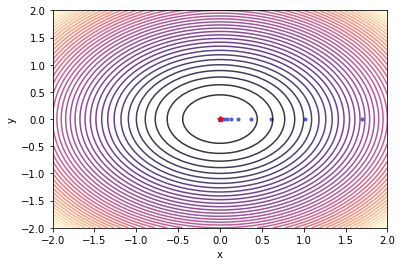

In [17]:
# Visualize iterations.
bp.visualize(iters, plot_x_lim=2, plot_y_lim=2)